# Fireball and NASA API

![alt text](https://i0.wp.com/articolidiastronomia.com/wp-content/uploads/2021/01/cropped-cropped-icona-21-2.jpeg?w=1600&ssl=1)

External Documents: 

* https://ssd-api.jpl.nasa.gov/doc/fireball.html
* https://cneos.jpl.nasa.gov/fireballs/

In [90]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Import libraries

In [91]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import matplotlib

import json

from datetime import date
import datetime

import io
import re

import requests
import folium
import folium.plugins as plugins
import datetime as dt

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from ipywidgets import interact, widgets

def get_start_year(x):
    return x


In [94]:
a = interact(get_start_year, x = widgets.IntSlider(min=1992,max=2021,value=0))

interactive(children=(IntSlider(value=1992, description='x', max=2021, min=1992), Output()), _dom_classes=('wi…

In [97]:
a.value()

AttributeError: 'function' object has no attribute 'value'

In [82]:
#payload = {'limit': 20, "api_key": "RURa4gu9m21i3jitYPq9gXgZdfWMuOMZ1Au3fumL"}
payload = {'date-min': '1992-10-17','date-max': '2020-10-18'}

r = requests.get("https://ssd-api.jpl.nasa.gov/fireball.api", params = payload)
print('Url format:',r.url)
ans = r.json()

Url format: https://ssd-api.jpl.nasa.gov/fireball.api?date-min=1992-10-17&date-max=2020-10-18


In [83]:
count = ans['count']
print('NASA API retrieved ', count, ' fireballs')

NASA API retrieved  836  fireballs


In [5]:
fields = ans['fields']
distrib_FIREBALL = ans ['data']
df = pd.DataFrame(distrib_FIREBALL, columns = fields)
df.head()
# power of Hiroshima bomb for comparison of term (impact-e): 15 kiloton

,date,energy,impact-e,lat,lat-dir,lon,lon-dir,alt,vel
0,2020-09-18 08:05:27,4.1,0.14,2.4,N,169.7,W,46.0,11.7
1,2020-08-30 16:08:22,6.4,0.2,26.0,N,133.5,E,27.8,23.4
2,2020-08-02 16:36:25,7.4,0.23,35.1,S,34.2,W,38.0,11.1
3,2020-07-22 02:55:40,2.2,0.079,20.0,S,103.8,W,36.0,None
4,2020-07-20 21:25:09,5.0,0.16,51.8,S,11.2,W,31.6,14.1


In [6]:
df.shape

(652, 9)

In [7]:
df

,date,energy,impact-e,lat,lat-dir,lon,lon-dir,alt,vel
0,2020-09-18 08:05:27,4.1,0.14,2.4,N,169.7,W,46.0,11.7
1,2020-08-30 16:08:22,6.4,0.2,26.0,N,133.5,E,27.8,23.4
2,2020-08-02 16:36:25,7.4,0.23,35.1,S,34.2,W,38.0,11.1
3,2020-07-22 02:55:40,2.2,0.079,20.0,S,103.8,W,36.0,None
4,2020-07-20 21:25:09,5.0,0.16,51.8,S,11.2,W,31.6,14.1
...,...,...,...,...,...,...,...,...,...
647,2001-12-12 16:56:13,9.8,0.3,None,None,None,None,None,None
648,2001-11-26 06:51:52,19.2,0.54,None,None,None,None,None,None
649,2001-11-13 10:58:48,31.2,0.83,None,None,None,None,None,None
650,2001-11-11 12:14:02,13.0,0.38,None,None,None,None,None,None


In [8]:
df.dropna(axis=0, subset=['lat','lon'], inplace=True)

In [9]:
#null_columns = df.columns[df.isnull().any()]
#df[null_columns].isnull().sum()

In [10]:
df.shape

(548, 9)

In [11]:
df.dtypes

date        object
energy      object
impact-e    object
lat         object
lat-dir     object
lon         object
lon-dir     object
alt         object
vel         object
dtype: object

In [12]:
df.rename(columns={"lat-dir": "latdir", "lon-dir": "londir"}, inplace=True)

In [13]:
df['Latitude'] = df['latdir'].apply(lambda x: '-' if x=='S' else '+') + df['lat']

In [14]:
df['Longitude'] = df['londir'].apply(lambda x: '-' if x=='W' else '+') + df['lon']

In [15]:
df.head()

,date,energy,impact-e,lat,latdir,lon,londir,alt,vel,Latitude,Longitude
0,2020-09-18 08:05:27,4.1,0.14,2.4,N,169.7,W,46.0,11.7,+2.4,-169.7
1,2020-08-30 16:08:22,6.4,0.2,26.0,N,133.5,E,27.8,23.4,+26.0,+133.5
2,2020-08-02 16:36:25,7.4,0.23,35.1,S,34.2,W,38.0,11.1,-35.1,-34.2
3,2020-07-22 02:55:40,2.2,0.079,20.0,S,103.8,W,36.0,None,-20.0,-103.8
4,2020-07-20 21:25:09,5.0,0.16,51.8,S,11.2,W,31.6,14.1,-51.8,-11.2


In [28]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
df['energy'] = df['energy'].astype(float)
df['impact-e'] = df['impact-e'].astype(float)
df['year'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').dt.year
df['year'] = df['year'].astype(int)
df['vel'] = df['vel'].astype(float)

df.head()

,date,energy,impact-e,lat,latdir,lon,londir,alt,vel,Latitude,Longitude,energy_scaled,year
0,2020-09-18 08:05:27,4.1,0.140,2.4,N,169.7,W,46.0,11.7,2.4,-169.7,0.000056,2020
1,2020-08-30 16:08:22,6.4,0.200,26.0,N,133.5,E,27.8,23.4,26.0,133.5,0.000117,2020
2,2020-08-02 16:36:25,7.4,0.230,35.1,S,34.2,W,38.0,11.1,-35.1,-34.2,0.000144,2020
3,2020-07-22 02:55:40,2.2,0.079,20.0,S,103.8,W,36.0,NaN,-20.0,-103.8,0.000005,2020
4,2020-07-20 21:25:09,5.0,0.160,51.8,S,11.2,W,31.6,14.1,-51.8,-11.2,0.000080,2020


In [18]:
centerLat = df["Latitude"].mean()
centerLon = df["Longitude"].mean()
max_energy = df["impact-e"].max()
location = [centerLat, centerLon]

map_world = folium.Map(location,tiles='Stamen Terrain',zoom_start=4)

for i in range(len(df)):
        lat = df.iloc[i]['Latitude']
        long = df.iloc[i]['Longitude']
        popup_text = """Date: {} """
        popup_text = popup_text.format(df.iloc[i]['date'])
        #popup_text = popup_text.format(df.iloc[i]['impact-e'])
        radius = df.iloc[i]['impact-e']/ max_energy * 100,
        #radius = 5,
        folium.Marker(location = [lat, long], 
                            color="#007849", 
                            fill=True, 
                            popup = popup_text).add_to(map_world)

map_world

In [19]:
centerLat = df["Latitude"].mean()
centerLon = df["Longitude"].mean()
max_energy = df["impact-e"].max()
location = [centerLat, centerLon]

map_world = folium.Map(location,tiles='Stamen Terrain',zoom_start=4)

for i in range(len(df)):
        lat = df.iloc[i]['Latitude']
        long = df.iloc[i]['Longitude'],
        folium.Circle(location = [df.iloc[i]['Latitude'], df.iloc[i]['Longitude']],
                      popup=df.iloc[i]['date'],
                      radius=df.iloc[i]['impact-e']*350,
                      #radius=150,
                      color="crimson", 
                      fill=True).add_to(map_world)

map_world

In [20]:
data_heat = df[['Latitude','Longitude','energy']].values.tolist()

In [21]:
import folium.plugins as plugins

m = folium.Map(location=location,  tiles='Stamen Terrain', zoom_start=4)
plugins.HeatMap(data = data_heat, overlay =  False, blur = 10).add_to(m)
m

In [22]:
year = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').dt.year
distrib_per_year = pd.DataFrame.from_dict(year.value_counts()).sort_index()
distrib_per_year.rename(columns={"date": "number of fireballs"}, inplace=True)

Text(0, 0.5, 'Number')

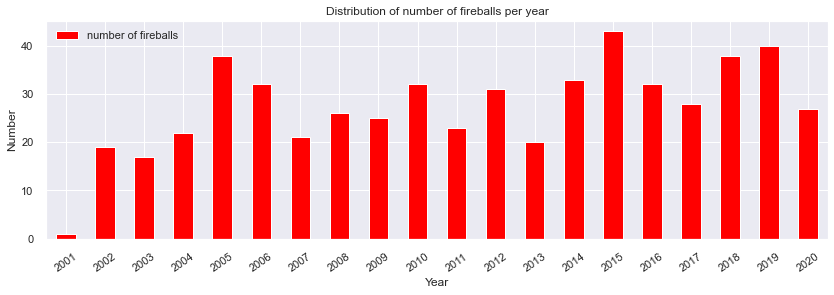

In [26]:
sns.set(rc={'figure.figsize':(14, 4)})

year_bar = distrib_per_year.plot.bar(y='number of fireballs', color='red', align='center', rot=110)
year_bar.legend(loc=2)  

matplotlib.style.use('seaborn') 

plt.xticks(rotation=35, horizontalalignment="center")
plt.title("Distribution of number of fireballs per year")
plt.xlabel("Year")
plt.ylabel("Number")

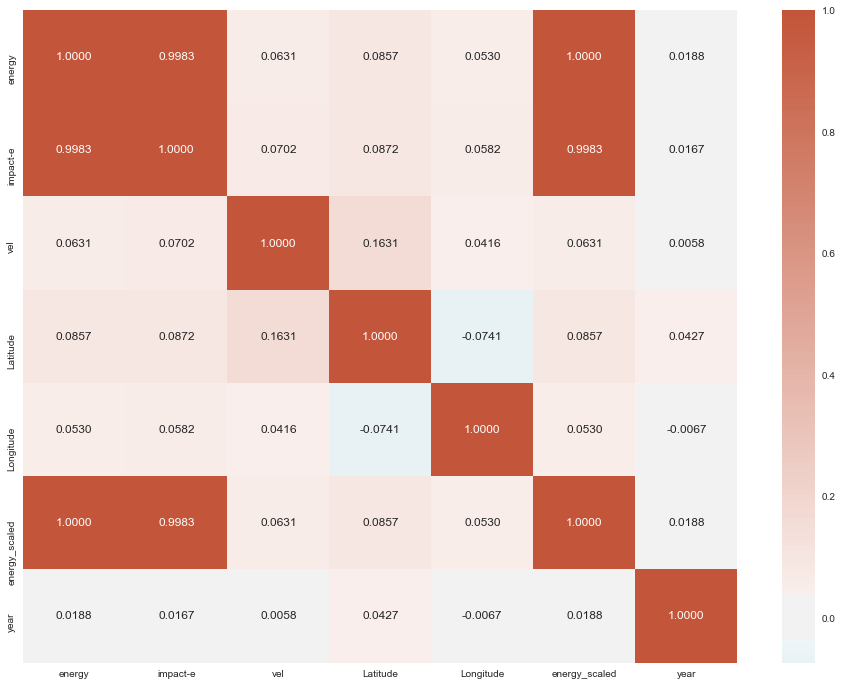

In [29]:
import seaborn as sns
import matplotlib.cm as cm

plt.figure(figsize = (16.0,12.0))
sns.heatmap(df.corr(),
            xticklabels = df.corr().columns.values,
            yticklabels = df.corr().columns.values, 
            cmap = sns.diverging_palette(220, 20, as_cmap=True),
            center = 0., 
            annot = True, fmt = '.4f' )

plt.show()

In [31]:
new_df = df.dropna(axis=0, subset=['energy','vel','impact-e'])

In [32]:
df

,date,energy,impact-e,lat,latdir,lon,londir,alt,vel,Latitude,Longitude,energy_scaled,year
0,2020-09-18 08:05:27,4.1,0.140,2.4,N,169.7,W,46.0,11.7,2.4,-169.7,0.000056,2020
1,2020-08-30 16:08:22,6.4,0.200,26.0,N,133.5,E,27.8,23.4,26.0,133.5,0.000117,2020
2,2020-08-02 16:36:25,7.4,0.230,35.1,S,34.2,W,38.0,11.1,-35.1,-34.2,0.000144,2020
3,2020-07-22 02:55:40,2.2,0.079,20.0,S,103.8,W,36.0,NaN,-20.0,-103.8,0.000005,2020
4,2020-07-20 21:25:09,5.0,0.160,51.8,S,11.2,W,31.6,14.1,-51.8,-11.2,0.000080,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,2002-03-01 03:53:59,3.8,0.130,29.2,N,66.8,W,None,NaN,29.2,-66.8,0.000048,2002
642,2002-02-09 19:50:26,7.0,0.220,17.7,S,138.7,E,None,NaN,-17.7,138.7,0.000133,2002
643,2002-02-01 19:07:54,7.0,0.220,60.7,N,116.6,E,None,NaN,60.7,116.6,0.000133,2002
644,2002-01-20 16:42:04,10.4,0.310,48.4,N,165.0,W,None,NaN,48.4,-165.0,0.000224,2002


In [17]:
column_names_to_normalize = ['energy']
x = df[column_names_to_normalize].values

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
df['energy_scaled'] = df_temp
df.head()

,date,energy,impact-e,lat,latdir,lon,londir,alt,vel,Latitude,Longitude,energy_scaled
0,2020-09-18 08:05:27,4.1,0.140,2.4,N,169.7,W,46.0,11.7,2.4,-169.7,0.000056
1,2020-08-30 16:08:22,6.4,0.200,26.0,N,133.5,E,27.8,23.4,26.0,133.5,0.000117
2,2020-08-02 16:36:25,7.4,0.230,35.1,S,34.2,W,38.0,11.1,-35.1,-34.2,0.000144
3,2020-07-22 02:55:40,2.2,0.079,20.0,S,103.8,W,36.0,None,-20.0,-103.8,0.000005
4,2020-07-20 21:25:09,5.0,0.160,51.8,S,11.2,W,31.6,14.1,-51.8,-11.2,0.000080


Text(0, 0.5, 'Energy')

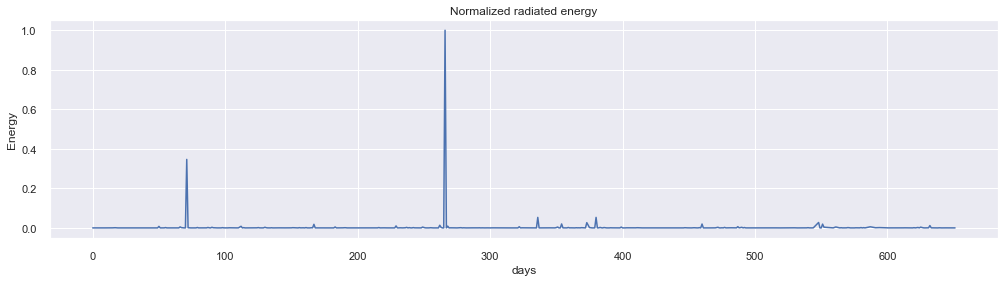

In [45]:
df['day'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
sns.set(rc={'figure.figsize':(17, 4)})
df['energy_scaled'].plot(linewidth=1.5);
plt.title('Normalized radiated energy')
plt.xlabel("days")
plt.ylabel("Energy")

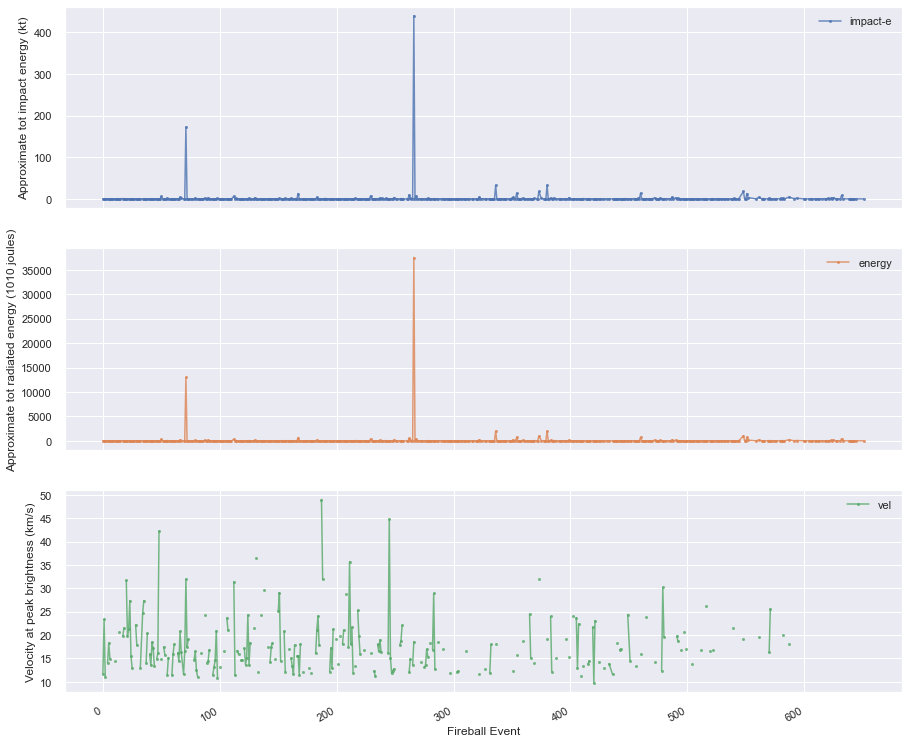

In [56]:
sns.set(rc={'figure.figsize':(15, 14)})
cols_plot = ['impact-e', 'energy', 'vel', 'alt']
axes = df[cols_plot].plot(marker='.', alpha=0.8, linestyle='-', figsize=(15, 14), subplots=True)

y_labels = ['Approximate tot impact energy (kt)', 
            'Approximate tot radiated energy (1010 joules)', 
            'Velocity at peak brightness (km/s)',
            'Altitude above the geoid at peak brightness (km)']
i = 0
for ax in axes:
    ax.set_ylabel(y_labels[i])
    ax.set_xlabel('Fireball Event')
    i = i + 1


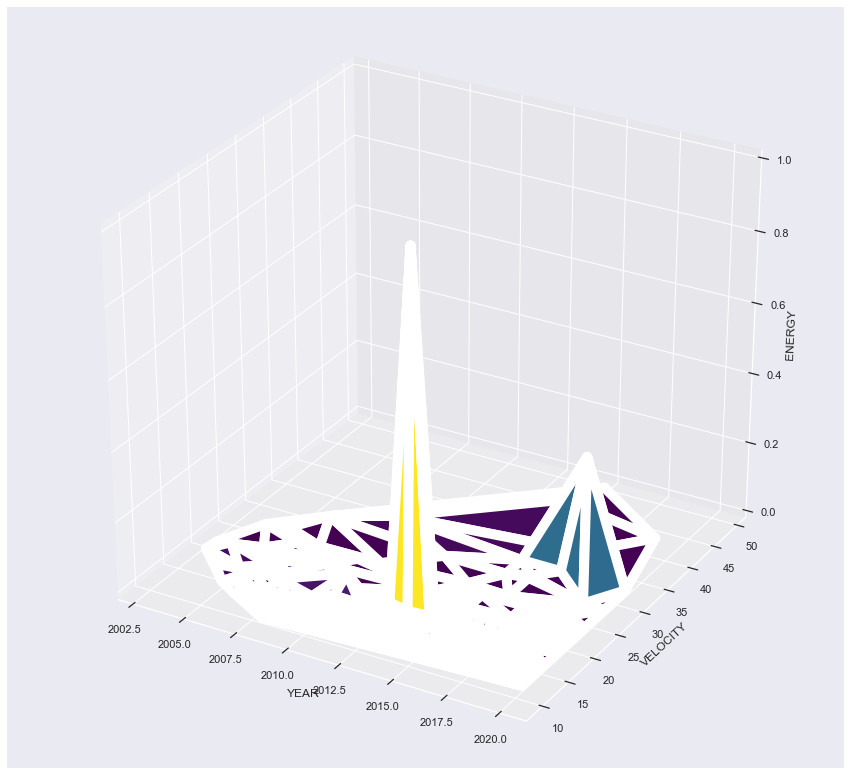

In [66]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('YEAR')
ax.set_ylabel('VELOCITY')
ax.set_zlabel('ENERGY')
ax.plot_trisurf(new_df['year'], new_df['vel'], new_df['energy_scaled'], cmap=plt.cm.viridis, linewidth=10)
plt.show()

# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(new_df['year'], new_df['vel'], new_df['energy_scaled'], cmap=plt.cm.viridis, linewidth=10)
fig.colorbar( surf, shrink=0.5, aspect=3)
plt.show()

# Rotate it
ax.view_init(30, 45)
plt.show()

# Other palette
ax.plot_trisurf(new_df['year'], new_df['vel'], new_df['energy_scaled'], cmap=plt.cm.jet, linewidth=1)
plt.show()

In [59]:
new_df[new_df.energy == new_df.energy.max()]

,date,energy,impact-e,lat,latdir,lon,londir,alt,vel,Latitude,Longitude,energy_scaled,year
266,2013-02-15 03:20:33,37500.0,440.0,54.8,N,61.1,E,23.3,18.6,54.8,61.1,1.0,2013


In [60]:
#remove the most impactness event
new_df_2 = new_df.loc[new_df['energy']!=new_df['energy'].max()]

In [61]:
new_df_2[new_df_2.energy == new_df_2.energy.max()]

,date,energy,impact-e,lat,latdir,lon,londir,alt,vel,Latitude,Longitude,energy_scaled,year
71,2018-12-18 23:48:20,13000.0,173.0,56.9,N,172.4,E,25.6,32.0,56.9,172.4,0.346632,2018


In [62]:
new_df_3 = new_df_2.loc[new_df_2['energy']!=new_df_2['energy'].max()]

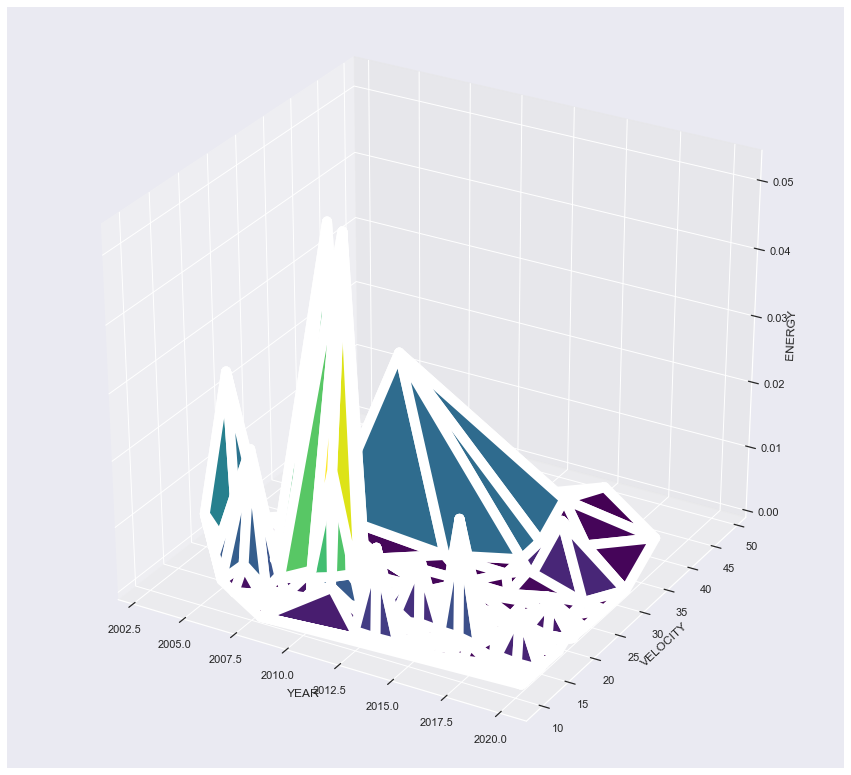

In [67]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('YEAR')
ax.set_ylabel('VELOCITY')
ax.set_zlabel('ENERGY')
ax.plot_trisurf(new_df_3['year'], new_df_3['vel'], new_df_3['energy_scaled'], cmap=plt.cm.viridis, linewidth=10)
plt.show()

# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(new_df_3['year'], new_df_3['vel'], new_df_3['energy_scaled'], cmap=plt.cm.viridis, linewidth=10)
fig.colorbar( surf, shrink=0.5, aspect=3)
plt.show()

# Rotate it
ax.view_init(30, 45)
plt.show()

# Other palette
ax.plot_trisurf(new_df_3['year'], new_df_3['vel'], new_df_3['energy_scaled'], cmap=plt.cm.jet, linewidth=1)
plt.show()